In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
ens_method = "rand_init"
ens_method_ls = [
    "rand_init",
    "bagging",
    "batchensemble",
    "bayesian",
    "mc_dropout",
    "variational_dropout",
    "concrete_dropout",
]
ens_method_labels = {
    "rand_init": "Naive",
    "bagging": "Bagging",
    "batchensemble": "BatchEns.",
    "bayesian": "Bayesian",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Var. Dropout",
    "concrete_dropout": "Conc. Dropout",
}
dataset_ls = [
    "boston",
    "concrete",
    "energy",
    "kin8nm",
    "naval",
    "power",
    "protein",
    "wine",
    "yacht",
]
dataset_labels = {
    "boston": "Boston Housing \n (N=506)",
    "concrete": "Concrete Strength \n (N=1030)",
    "energy": "Energy Efficiency \n (N=768)",
    "kin8nm": "Kin8nm \n (N=8192)",
    "naval": "Naval Propulsion \n (N=11934)",
    "power": "Power Plant \n (N=9568)",
    "protein": "Protein Structure \n (N=45730)",
    "wine": "Wine Quality Red \n (N=1599)",
    "yacht": "Yacht Hydrodynamics \n (N=308)"
}

In [14]:
# Get colors
agg_cols = sns.color_palette("Dark2", 8, as_cmap=True)
# Colors of aggregation methods
agg_col = {
    "lp": agg_cols.colors[4],  # type: ignore
    "vi": agg_cols.colors[5],  # type: ignore
    "vi-a": agg_cols.colors[2],  # type: ignore
    "vi-w": agg_cols.colors[0],  # type: ignore
    "vi-aw": agg_cols.colors[3],  # type: ignore
    "ens": agg_cols.colors[7],  # type: ignore
    "opt": agg_cols.colors[1],  # type: ignore
}

greens = sns.color_palette("Greens", 2, as_cmap=False)
blues = sns.color_palette("Blues", 1)
purples = sns.color_palette("Purples", 1)
reds = sns.color_palette("Reds", 3)
ens_col = {
    "rand_init": greens[1], #multi_model_cols.colors[0],  # type: ignore
    "bagging": greens[0], #multi_model_cols.colors[1],  # type: ignore
    "batchensemble": blues[0], #multi_model_cols.colors[3],  # type: ignore
    "bayesian": purples[0], #multi_model_cols.colors[8],  # type: ignore
    "mc_dropout": reds[2], #dropout_cols.colors[14],  # type: ignore
    "variational_dropout": reds[1], #dropout_cols.colors[16],  # type: ignore
    "concrete_dropout": reds[0], #dropout_cols.colors[15],  # type: ignore
}

# KIT colors
kit_cols_dict = {
    "green": "#00876C",
    "blue": "#4664AA",
    "black": "#000000",
    "grey": "#404040",
}

In [15]:
score_vec = ["crps", "crpss", "me", "lgt", "cov", "a", "w"]
nn_vec = ["drn", "bqn"]
n_ens_vec = np.arange(start=2, stop=10 + 2, step=2)
agg_meths = ["lp", "vi", "vi-a", "vi-w", "vi-aw"]

In [16]:
export = True
save_dir = os.path.join("plots", "results")

# Get runtime for training and prediction

In [17]:
data_path = os.path.join("..", "..", "04_Experiments", f"MC Dropout 100")

In [18]:
ens_method_ls = ["mc_dropout"]

In [19]:
df_final = pd.DataFrame()

for dataset in dataset_ls:
    for ens_method in ens_method_ls:
        dir_path = os.path.join(data_path, dataset, ens_method)
        filename = f"runtime_{dataset}_{ens_method}.pkl"
        with open(os.path.join(data_path, filename), "rb") as f:
            df_runtime = pickle.load(f)
        df_runtime["ens_method"] = ens_method
        
        df_final = pd.concat(
            [
                df_final,
                pd.DataFrame(df_runtime),
            ],
            ignore_index=True,
        )

df_final["runtime_train_s"] = df_final["runtime_train"] / 1e+9
df_final["runtime_pred_s"] = df_final["runtime_pred"] / 1e+9


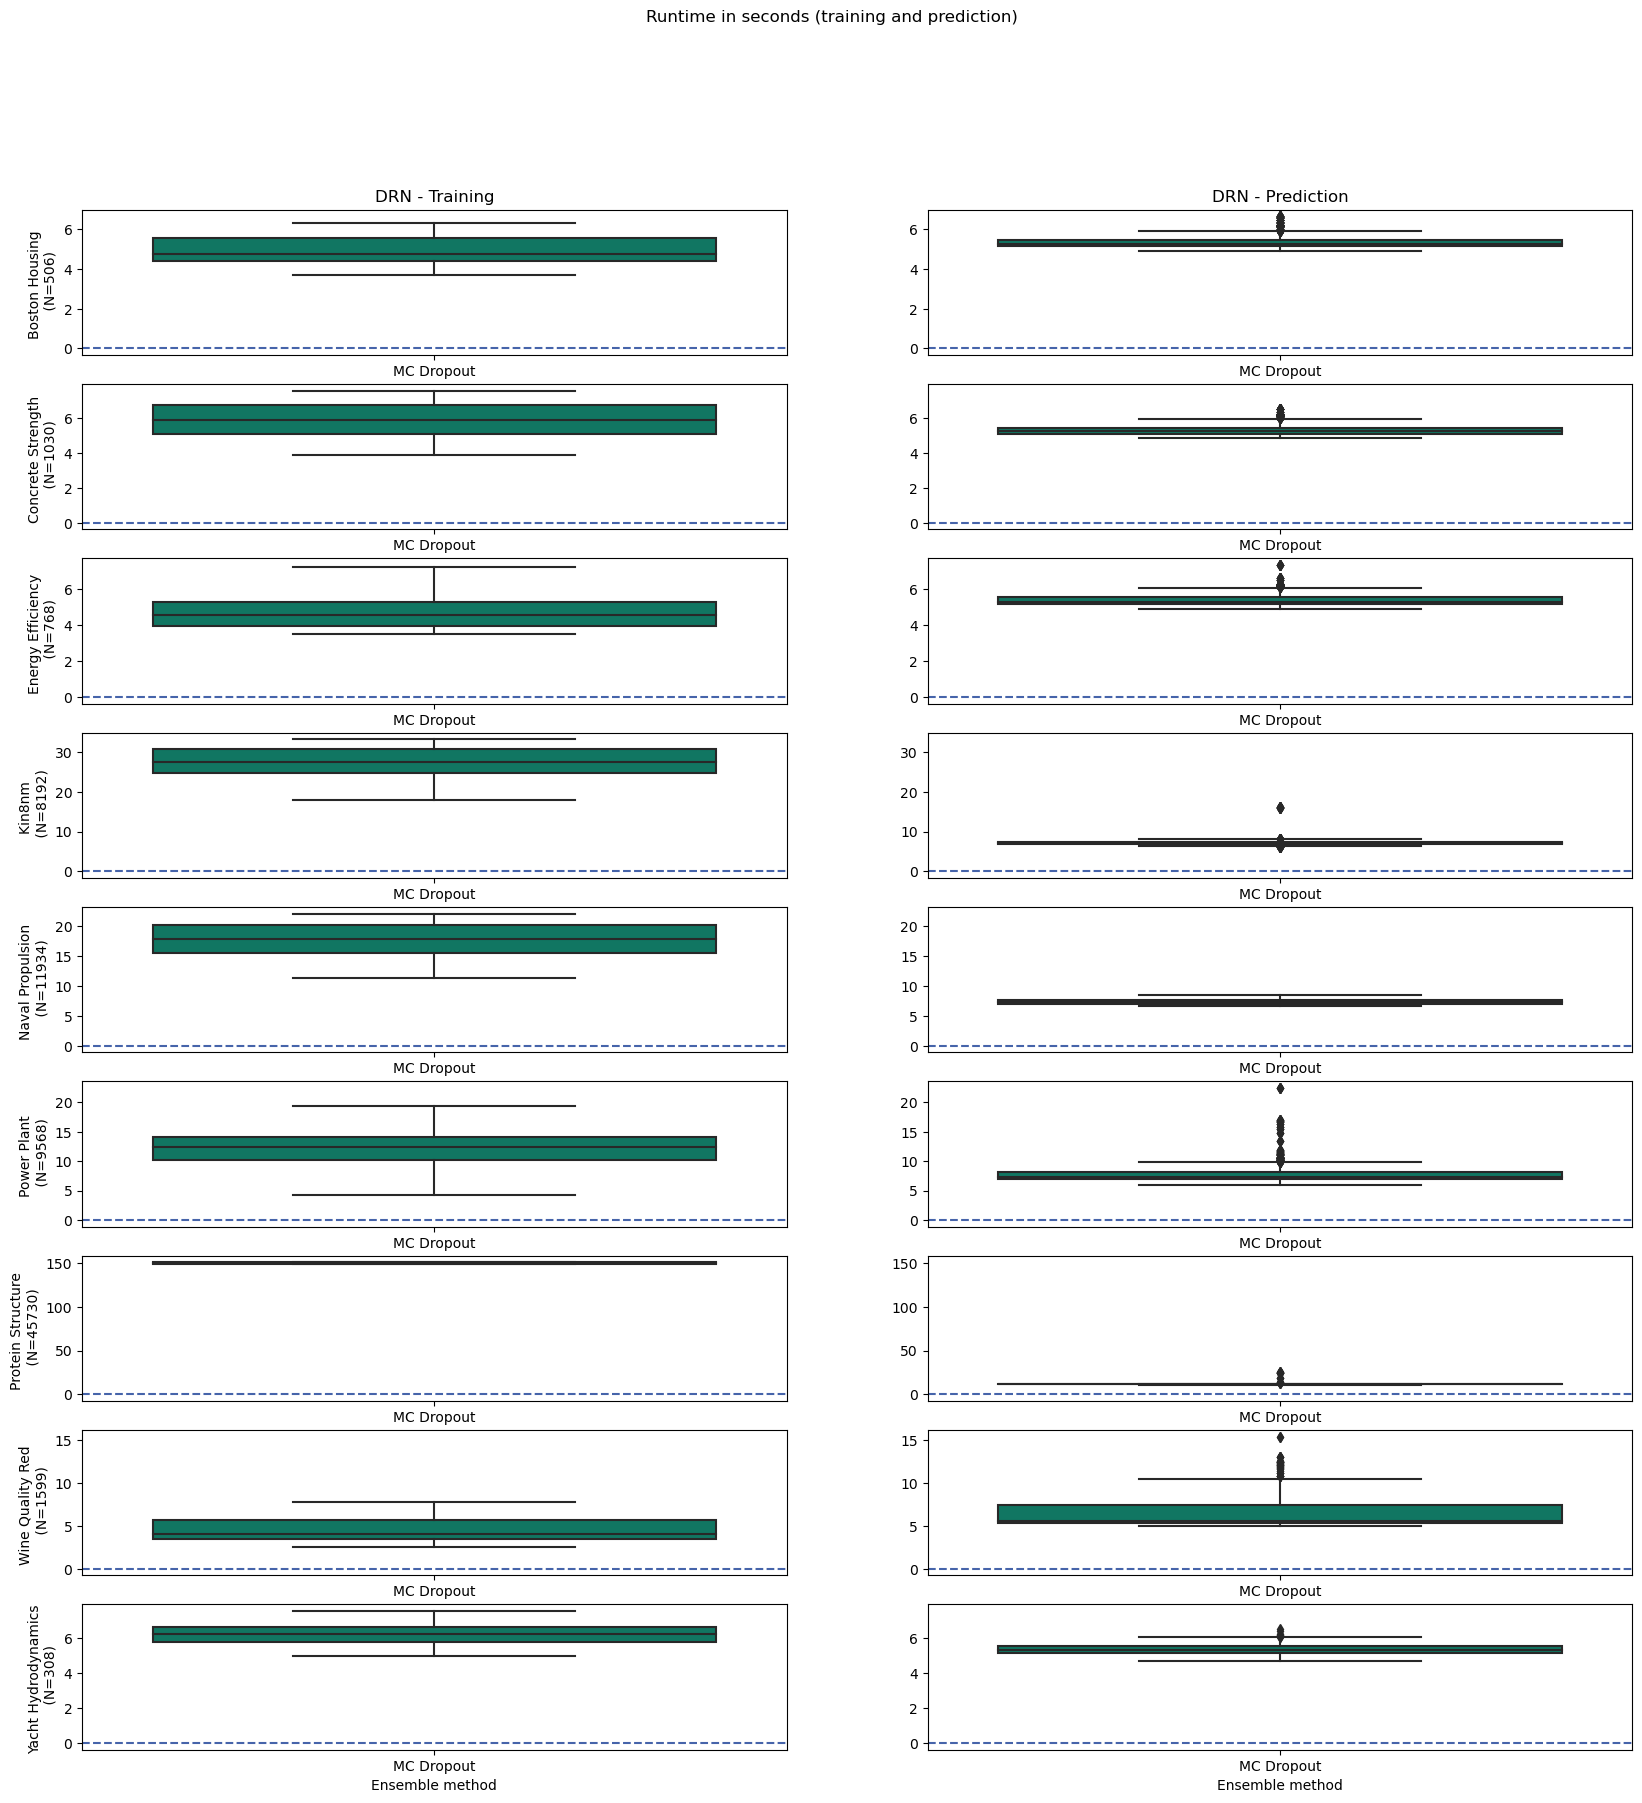

In [22]:
##### Skill - Boxplots - x=aggregation_methods #####

# Temp:
nn_vec = df_final["nn"].unique()

# Create subplots
fig, axs = plt.subplots(nrows=len(dataset_ls), ncols=len(nn_vec)*2, figsize=(20,20), squeeze=False)

# Iterate over NN types and datasets
for i_nn, nn in enumerate(nn_vec):
    df_nn = df_final[df_final["nn"] == nn]
    for i_dataset, dataset in enumerate(dataset_ls):
        df_nn_dataset = df_nn[(df_nn["dataset"] == dataset)]
        
        #### Train runtime ####                
        # Plot boxplots
        f = sns.boxplot(ax=axs[i_dataset][i_nn], data=df_nn_dataset, y="runtime_train_s", x="ens_method", showfliers=False, color=kit_cols_dict["green"])
        g = sns.boxplot(ax=axs[i_dataset][len(nn_vec)+i_nn], data=df_nn_dataset, y="runtime_pred_s", x="ens_method", showfliers=True, color=kit_cols_dict["green"])
        
        # Add 0 line
        f.axhline(0, linestyle="--", color=kit_cols_dict["blue"])
        g.axhline(0, linestyle="--", color=kit_cols_dict["blue"])
        # Add labels to x and y axis
        axs[i_dataset][i_nn].set_ylabel("")
        axs[i_dataset][len(nn_vec)+i_nn].set_ylabel("")
        axs[i_dataset][0].set_ylabel(dataset_labels[dataset])
        axs[i_dataset][i_nn].set_xticklabels([ens_method_labels.get(ens_method) for ens_method in ens_method_ls])
        axs[i_dataset][len(nn_vec)+i_nn].set_xticklabels([ens_method_labels.get(ens_method) for ens_method in ens_method_ls])
        axs[len(dataset_ls)-1][i_nn].set_xlabel("Ensemble method")
        axs[len(dataset_ls)-1][len(nn_vec)+i_nn].set_xlabel("Ensemble method")
        # Set titles
        axs[0][i_nn].set_title(f"{nn.upper()} - Training")
        axs[0][len(nn_vec)+i_nn].set_title(f"{nn.upper()} - Prediction")


# # Remove subplot legends and add figure legend
for ax in [item for sublist in axs for item in sublist]:
    ax.legend([],[], frameon=False)
handles, labels = axs[0][0].get_legend_handles_labels()

# Set y axis range
for ax_drn, ax_bqn in axs:
    drn_l, drn_u = ax_drn.get_ylim()
    bqn_l, bqn_u = ax_bqn.get_ylim()
    
    ax_drn.set_ylim(min(drn_l, bqn_l), max(drn_u, bqn_u))
    ax_bqn.set_ylim(min(drn_l, bqn_l), max(drn_u, bqn_u))

# Set titles and legends
fig.suptitle(f"Runtime in seconds (training and prediction)")

# Save figure
if export:
    filename=os.path.join(save_dir, "05_runtime_boxplot.pdf")
    fig.savefig(filename, bbox_inches='tight')
    filename=os.path.join(save_dir, "05_runtime_boxplot.png")
    fig.savefig(filename, bbox_inches='tight')